In [1]:
!pip install nltk

In [2]:
!pip install textblob

In [3]:
!pip install spacy

In [4]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 72.0 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Code Starts

In [5]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import math
import itertools

import nltk

from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

In [6]:
# Load in training data and display in pandas dataframe
train_path = "training.csv"
train_data = pd.read_csv(train_path, delimiter="\t", skip_blank_lines=True)
val_path = "val.csv"
val_data = pd.read_csv(val_path, delimiter="\t", skip_blank_lines=True)
test_path = "test.csv"
test_data = pd.read_csv(test_path, delimiter="\t", skip_blank_lines=True)

# Inspect
train_data

,Episode,Scene,Character_name,Line,Gender
0,s01e01,c01,Monica Geller,There's nothing to tell! He's just some guy I work with!,Female
1,s01e01,c01,Joey Tribbiani,"C'mon, you're going out with the guy! There's gotta be something wrong with him!",Male
2,s01e01,c01,Chandler Bing,"All right Joey, be nice. So does he have a hump? A hump and a hairpiece?",Male
3,s01e01,c01,Phoebe Buffay,"Wait, does he eat chalk?",Female
4,s01e01,c01,Phoebe Buffay,"Just, 'cause, I don't want her to go through what I went through with Carl- oh!",Female
...,...,...,...,...,...
53548,s03e25,c12,Ross Geller,Hi.,Male
53549,s03e25,c13,Chandler Bing,Hi there.,Male
53550,s03e25,c13,Monica Geller,That's that weird voice again.,Female
53551,s03e25,c13,Chandler Bing,"Okay! Okay! Let me try it again, you're gonna wanna date this next guy, I swear!",Male


In [7]:
# Create one document per character
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them

    Improve this for Q3

    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}
    for line, name, gender in zip(df.Line, df.Character_name, df.Gender):
        # remove the empty lines
        if (isinstance(line, float) and math.isnan(line)) or line == "":
            continue
        if not name in character_docs.keys():
            character_docs[name] = ""
            character_line_count[name] = 0
        if character_line_count[name] == max_line_count:
            continue
        character_docs[name] += str(line) + " _EOL_ "  # adding an end-of-line token
        character_line_count[name] += 1
    print("lines per character", character_line_count)
    return character_docs

In [8]:
# print out the number of words each character has in the training set
# only use the first 300 lines of each character
train_character_docs = create_character_document_from_dataframe(
    train_data, max_line_count=300
)
print("Num. Characters: ", len(train_character_docs.keys()), "\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, "Number of Words: ", len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'Monica Geller': 300, 'Joey Tribbiani': 300, 'Chandler Bing': 300, 'Phoebe Buffay': 300, '#ALL#': 300, 'Ross Geller': 300, 'Rachel Green': 300, 'Other_None': 300, 'Other_Female': 300, 'Other_Male': 300}
Num. Characters:  10 

Monica Geller Number of Words:  2937
Joey Tribbiani Number of Words:  3119
Chandler Bing Number of Words:  3963
Phoebe Buffay Number of Words:  3448
#ALL# Number of Words:  999
Ross Geller Number of Words:  3477
Rachel Green Number of Words:  3725
Other_None Number of Words:  2920
Other_Female Number of Words:  2765
Other_Male Number of Words:  3168
total words 30521


In [9]:
print("Sample Document:\n", train_character_docs["Monica Geller"])

Sample Document:
 There's nothing to tell! He's just some guy I work with! _EOL_ Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex. _EOL_ And they weren't looking at you before?! _EOL_ Are you okay, sweetie? _EOL_ Carol moved her stuff out today. _EOL_ Let me get you some coffee. _EOL_ No you don't. _EOL_ Oh really, so that hysterical phone call I got from a woman at sobbing 3:00 A.M., I'll never have grandchildren, I'll never have grandchildren." was what? A wrong number?" _EOL_ Rachel?! _EOL_ De-caff. Okay, everybody, this is Rachel, another Lincoln High survivor. This is everybody, this is Chandler, and Phoebe, and Joey, and- you remember my brother Ross? _EOL_ So you wanna tell us now, or are we waiting for four wet bridesmaids? _EOL_ Who wasn't invited to the wedding. _EOL_ Now I'm guessing that he bought her the big pipe organ, and she's really not happy about it. _EOL_ Well, I guess we've established who's staying here w

In [10]:
def pre_process(character_text):
    """Pre-process all the concatenated lines of a character,
    using tokenization, spelling normalization and other techniques.

    Initially just a tokenization on white space. Improve this for Q1.

    ::character_text:: a string with all of one character's lines
    """
    tokens = character_text.split()  # just a simple tokenization, to be replaced
    return tokens

In [11]:
# create list of pairs of (character name, pre-processed character)
training_corpus = [
    (name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())
]
train_labels = [name for name, doc in training_corpus]

In [12]:
print(training_corpus[0])
print(train_labels[0])

('#ALL#', ['Oh,', 'yeah.', 'Had', 'that', 'dream.', '_EOL_', 'Hey!', 'Paul!', 'Hi!', 'The', 'Wine', 'Guy!', 'Hey!', '_EOL_', 'Morning.', 'Good', 'morning.', '_EOL_', 'Okayyy!', '_EOL_', 'Cut,', 'cut,', 'cut,', 'cut,', 'cut,', 'cut,', 'cut...', '_EOL_', 'Cut,', 'cut,', 'cut,', 'cut,', 'cut,', 'cut,', 'cut..', '_EOL_', 'Yes!', '_EOL_', 'Yeah.', 'Yeah,', "I'll", 'have', 'a', 'cup', 'of', 'coffee.', '_EOL_', 'Eeaagh!', '_EOL_', 'Hey,', 'Pheebs!', 'Hi!', '_EOL_', 'Ohh.', 'Ouch.', '_EOL_', 'Yeah.', 'Yeah,', 'excellent.', '_EOL_', 'Oh!', 'Oh,', 'God!', '_EOL_', 'Ohhh!', 'Put', 'it', 'out!', '_EOL_', 'Oh,', 'come', 'on!', 'Come', 'on!', '_EOL_', 'Yeah!', 'We', 'promise!', "We'll", 'be', 'good!', '_EOL_', 'Hi,', 'Alan.', '_EOL_', 'Loved', 'him!', 'Yeah!', "He's", 'great!', '_EOL_', 'Yeah!', '_EOL_', 'What?', '_EOL_', 'Yeah...', '_EOL_', 'WE', 'WON!!', 'Thank', 'you!', 'Yes!', '_EOL_', "You're", 'kidding.', 'Oh', 'my', 'God.', '_EOL_', 'Oh!', 'That', 'was', 'Lambchop!', '_EOL_', 'Oh,', 'yeah!', 

In [13]:
def to_feature_vector_dictionary(character_doc, extra_features):
    """Converts a list of pre-processed tokens and extra features
    to a Dictionary as a function of the tokens.

    Initially just a simple count. Improve this for Q2.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to feature vector dict
    """
    counts = Counter(character_doc)  # for now a simple count
    counts = dict(counts)
    # add the extra features, for now just adding one count for each extra feature
    for feature in extra_features:
        counts[feature] += 1
    return counts

In [14]:
# create a global corpus vectorizer
global corpusVectorizer
corpusVectorizer = (
    DictVectorizer()
)  # corpusVectorizor which will just produce sparse vectors from feature dicts
# Any matrix transformers (e.g. tf-idf transformers) should be initialized here


def create_document_matrix_from_corpus(corpus, fitting=False):
    """Method which fits different vectorizers
    on data and returns a matrix.

    Currently just does simple conversion to matrix by vectorizing the dictionary. Improve this for Q2.

    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """

    # uses the global variable of the corpus Vectorizer to improve things
    if fitting:
        corpusVectorizer.fit(
            [to_feature_vector_dictionary(doc, []) for name, doc in corpus]
        )
    doc_feature_matrix = corpusVectorizer.transform(
        [to_feature_vector_dictionary(doc, []) for name, doc in corpus]
    )

    return doc_feature_matrix


training_feature_matrix = create_document_matrix_from_corpus(
    training_corpus, fitting=True
)

In [15]:
training_feature_matrix

<10x5954 sparse matrix of type '<class 'numpy.float64'>'
	with 11502 stored elements in Compressed Sparse Row format>

In [16]:
# get the validation data- only 30 lines used for each character
val_character_docs = create_character_document_from_dataframe(
    val_data, max_line_count=30
)
print("Num. Characters: ", len(val_character_docs.keys()), "\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, "Num of Words: ", len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
val_corpus = [
    (name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())
]
val_labels = [name for name, doc in val_corpus]

lines per character {'Other_None': 30, 'Rachel Green': 30, 'Other_Male': 30, 'Ross Geller': 30, '#ALL#': 18, 'Phoebe Buffay': 30, 'Chandler Bing': 30, 'Monica Geller': 30, 'Joey Tribbiani': 30, 'Other_Female': 30}
Num. Characters:  10 

Other_None Num of Words:  397
Rachel Green Num of Words:  276
Other_Male Num of Words:  383
Ross Geller Num of Words:  242
#ALL# Num of Words:  77
Phoebe Buffay Num of Words:  359
Chandler Bing Num of Words:  299
Monica Geller Num of Words:  275
Joey Tribbiani Num of Words:  251
Other_Female Num of Words:  281
total words 2840


In [17]:
# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [18]:
val_feature_matrix

<10x5954 sparse matrix of type '<class 'numpy.float64'>'
	with 1429 stored elements in Compressed Sparse Row format>

In [19]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """

    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2) / (norm(v1) * norm(v2))

    return manual_cosine_similarity

In [20]:
def compute_IR_evaluation_scores(
    train_feature_matrix, test_feature_matrix, train_labels, test_labels
):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents

    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i
        # if not np array, convert to np array else just use it
        if not isinstance(test_feature_matrix, np.ndarray):
            fm_1 = test_feature_matrix.toarray()[idx]
        else:
            fm_1 = test_feature_matrix[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            # if not np array, convert to np array else just use it
            if not isinstance(train_feature_matrix, np.ndarray):
                fm_2 = train_feature_matrix.toarray()[j]
            else:
                fm_2 = train_feature_matrix[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(), key=lambda x: x[1], reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])
        # print("*****")
    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct / len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy)

    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame(
        {
            "doc1": [x[0] for x in pairs],
            "doc2": [x[1] for x in pairs],
            "similarity": pairwise_cosine_similarity,
        }
    )

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

In [21]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels = sorted(list(set(df.sort_values(["doc1"])["doc1"])))
    # add padding 1.0 values to either side
    cm = [
        [
            1.0,
        ]
        * (len(test_labels) + 2)
    ]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(["doc1", "doc2"])[df["doc1"] == target]["similarity"]:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append(
        [
            1.0,
        ]
        * (len(test_labels) + 2)
    )
    # print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title("Similarity matrix between documents as vectors")
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticklabels(labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(
                j, i, round(cm[i][j], 3), ha="center", va="center", color="w"
            )

    plt.xlabel("Training Vector Doc")
    plt.ylabel("Test Vector Doc")
    # fig.tight_layout()
    plt.show()

In [22]:
mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(
    training_feature_matrix, val_feature_matrix, train_labels, val_labels
)

mean rank 4.2
mean cosine similarity 0.8915725404768657
1 correct out of 10 / accuracy: 0.1


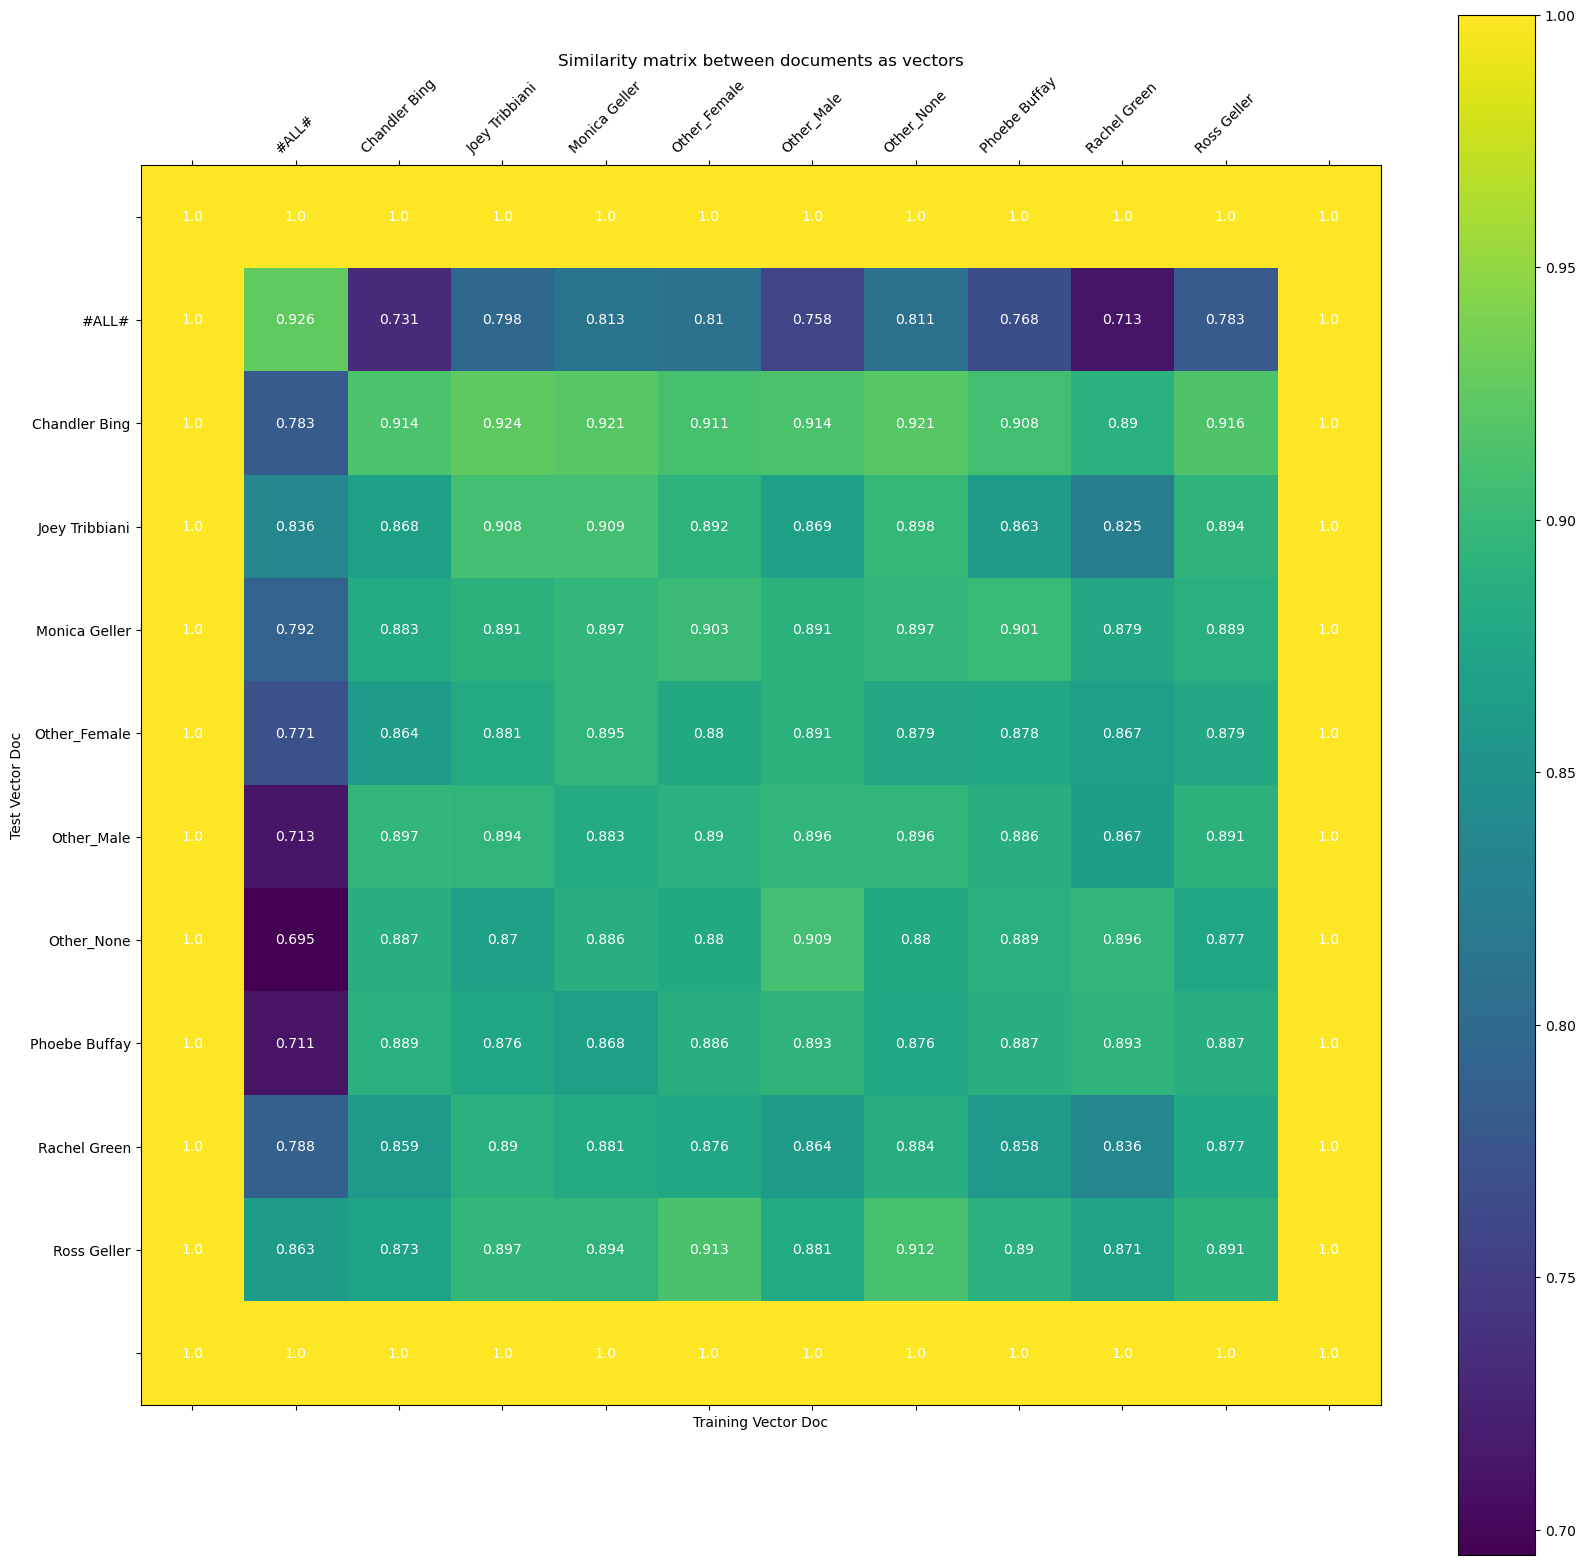

In [23]:
plot_heat_map_similarity(df)

# Q1. Improve pre-processing (20 marks)
Using the pre-processing techniques you have learned in the module, improve the `pre_process` function above, which currently just tokenizes text based on white space.

When developing, use the first 300 and 30 lines from the training and validation files, as per above. To check the improvements by using the different techniques, use the `compute_IR_evaluation_scores` function as above. The **mean rank** is the main metric you need to focus on improving throughout this assignment, where the target/best possible performance is **1** (i.e. all test/validation data character documents are closest to their corresponding training data character documents) and the worst is **10**. Initially, the code in this template achieves a mean rank of **4.0**  and accuracy of **0.3** on the test set and a mean rank of **4.2** and accuracy of **0.1** on the validation set - you should be looking to improve those, particularly getting the mean rank as close to 1 as possible.


In [24]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import TweetTokenizer
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.corpus import wordnet as wn
from nltk import pos_tag
import re

# Download necessary NLTK datasets
nltk.download("punkt")
nltk.download("stopwords")
nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")


def contractions(s):
    s = re.sub(r"won’t", "will not", s)
    s = re.sub(r"would’t", "would not", s)
    s = re.sub(r"could’t", "could not", s)
    s = re.sub(r"\’d", " would", s)
    s = re.sub(r"can\’t", "can not", s)
    s = re.sub(r"n\’t", " not", s)
    s = re.sub(r"\’re", " are", s)
    s = re.sub(r"\’s", " is", s)
    s = re.sub(r"\’ll", " will", s)
    s = re.sub(r"\’t", " not", s)
    s = re.sub(r"\’ve", " have", s)
    s = re.sub(r"\’m", " am", s)
    return s


def pre_process(character_text, tokenizer, expand_contractions):
    # Lowercase the text to normalize case differences
    character_text = character_text.lower()

    if expand_contractions:
        # Expand contractions
        character_text = contractions(character_text)

    # tokenization
    tokens = tokenizer.tokenize(character_text)

    # Remove stopwords while keeping negations
    stop_words = set(stopwords.words("english")) - {"no", "not"}
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization - converting words to their base form
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word, pos="v") for word in tokens]

    # Keep only nouns, adjectives, and verbs
    tokens = [word for word, pos in pos_tag(tokens) if pos in ["NN", "JJ", "VB"]]

    return tokens

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [25]:
from sklearn.feature_extraction import DictVectorizer


def evaluate_preprocessing(configs, train_character_docs, train_labels):
    print("#############################################################")
    print("Evaluating preprocessing configurations")
    best_score = float("-inf")
    best_config = None
    best_rank = float("inf")
    # global corpusVectorizer = DictVectorizer()
    # set the global corpusVectorizer to be an empty DictVectorizer
    global corpusVectorizer
    corpusVectorizer = (
        DictVectorizer()
    )  # corpusVectorizor which will just produce sparse vectors from feature dicts
    all_scores = []

    for config in configs:
        try:
            # Preprocess the training corpus using the current configuration
            processed_training_corpus = [
                (name, pre_process(doc, config["tokenizer"], config["expand_contractions"]))
                for name, doc in train_character_docs.items()
            ]

            # Create the training feature matrix
            training_feature_matrix = create_document_matrix_from_corpus(
                processed_training_corpus, fitting=True
            )

            # Get and preprocess the validation data
            val_character_docs = create_character_document_from_dataframe(
                val_data, max_line_count=30
            )
            val_corpus = [
                (name, pre_process(doc, config["tokenizer"], config["expand_contractions"]))
                for name, doc in val_character_docs.items()
            ]
            val_labels = [name for name, _ in val_corpus]

            # Just transform the val_feature_matrix, don't fit
            val_feature_matrix = create_document_matrix_from_corpus(
                val_corpus, fitting=False
            )

            # Compute IR evaluation scores
            mean_rank, mean_cosine_similarity, acc, df = compute_IR_evaluation_scores(
                training_feature_matrix, val_feature_matrix, train_labels, val_labels
            )

            # Add the scores to the list of all scores
            all_scores.append(
                {
                    "config": config,
                    "mean_rank": mean_rank,
                    "mean_cosine_similarity": mean_cosine_similarity,
                    "accuracy": acc,
                }
            )

            # Update the best score and configuration if the current configuration is better
            # if acc > best_score:
            if acc > best_score or (acc == best_score and mean_rank < best_rank):
                best_score = acc
                best_config = config
                best_rank = mean_rank
        except Exception as e:
            print("Error with config", config, ":", e)
            continue
    
    print("#############################################################")

    return best_config, best_score, best_rank, all_scores

In [26]:
# train_character_docs is a dictionary with character names as keys and dialogues as values
raw_corpus = list(train_character_docs.values())
train_labels = list(train_character_docs.keys())  # Labels are the character names

# Configurations
# preprocess_configs = [
#     {"tokenizer": TweetTokenizer(), "expand_contractions": True},
#     {"tokenizer": TweetTokenizer(), "expand_contractions": False},
#     {"tokenizer": RegexpTokenizer(r"\w+"), "expand_contractions": True},
#     {"tokenizer": RegexpTokenizer(r"\w+"), "expand_contractions": False},
# ]


# Define the parameters
tokenizers = [TweetTokenizer(), RegexpTokenizer(r"\w+")]
contraction_options = [True, False]

# Create combinations
combinations = itertools.product(tokenizers, contraction_options)

# Generate configurations
preprocess_configs = [
    {"tokenizer": tokenizer, "expand_contractions": expand_contractions}
    for tokenizer, expand_contractions in combinations
]

print("Total preprocess_configs Combinations : ", len(preprocess_configs))

# Run the grid search to find the best configuration
# best_config, best_score, best_rank, all_scores = evaluate_preprocessing(
#     configs, train_character_docs, train_labels
# )
(
    best_config_preprocess,
    best_score_preprocess,
    best_rank_preprocess,
    all_scores_preprocess,
) = evaluate_preprocessing(preprocess_configs, train_character_docs, train_labels)

Total preprocess_configs Combinations :  4
#############################################################
Evaluating preprocessing configurations
lines per character {'Other_None': 30, 'Rachel Green': 30, 'Other_Male': 30, 'Ross Geller': 30, '#ALL#': 18, 'Phoebe Buffay': 30, 'Chandler Bing': 30, 'Monica Geller': 30, 'Joey Tribbiani': 30, 'Other_Female': 30}
mean rank 3.3
mean cosine similarity 0.9073126799626173
5 correct out of 10 / accuracy: 0.5
lines per character {'Other_None': 30, 'Rachel Green': 30, 'Other_Male': 30, 'Ross Geller': 30, '#ALL#': 18, 'Phoebe Buffay': 30, 'Chandler Bing': 30, 'Monica Geller': 30, 'Joey Tribbiani': 30, 'Other_Female': 30}
mean rank 3.3
mean cosine similarity 0.9073126799626173
5 correct out of 10 / accuracy: 0.5
lines per character {'Other_None': 30, 'Rachel Green': 30, 'Other_Male': 30, 'Ross Geller': 30, '#ALL#': 18, 'Phoebe Buffay': 30, 'Chandler Bing': 30, 'Monica Geller': 30, 'Joey Tribbiani': 30, 'Other_Female': 30}
mean rank 2.9
mean cosine sim

In [27]:
# Output the best configuration and its score
print("Best configuration for preprocessing: ", best_config_preprocess)
print("Best accuracy for preprocessing: ", best_score_preprocess)
print("Best rank for preprocessing: ", best_rank_preprocess)
print("All Results for preprocessing: ", all_scores_preprocess)

Best configuration for preprocessing:  {'tokenizer': <nltk.tokenize.casual.TweetTokenizer object at 0x7f842a84efe0>, 'expand_contractions': True}
Best accuracy for preprocessing:  0.5
Best rank for preprocessing:  3.3
All Results for preprocessing:  [{'config': {'tokenizer': <nltk.tokenize.casual.TweetTokenizer object at 0x7f842a84efe0>, 'expand_contractions': True}, 'mean_rank': 3.3, 'mean_cosine_similarity': 0.9073126799626173, 'accuracy': 0.5}, {'config': {'tokenizer': <nltk.tokenize.casual.TweetTokenizer object at 0x7f842a84efe0>, 'expand_contractions': False}, 'mean_rank': 3.3, 'mean_cosine_similarity': 0.9073126799626173, 'accuracy': 0.5}, {'config': {'tokenizer': RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL), 'expand_contractions': True}, 'mean_rank': 2.9, 'mean_cosine_similarity': 0.6795839201077778, 'accuracy': 0.4}, {'config': {'tokenizer': RegexpTokenizer(pattern='\\w+', gaps=False, discard_empty=True, flags=re.UNICO

In [28]:
# Now you can process the entire corpus with the best configuration
best_tokenizer = best_config_preprocess["tokenizer"]
expand_contractions = best_config_preprocess["expand_contractions"]
training_corpus = [
    (name, pre_process(doc, best_tokenizer, expand_contractions))
    for name, doc in train_character_docs.items()
]

In [29]:
print("Sample Document:\n", train_character_docs["Monica Geller"])

Sample Document:
 There's nothing to tell! He's just some guy I work with! _EOL_ Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex. _EOL_ And they weren't looking at you before?! _EOL_ Are you okay, sweetie? _EOL_ Carol moved her stuff out today. _EOL_ Let me get you some coffee. _EOL_ No you don't. _EOL_ Oh really, so that hysterical phone call I got from a woman at sobbing 3:00 A.M., I'll never have grandchildren, I'll never have grandchildren." was what? A wrong number?" _EOL_ Rachel?! _EOL_ De-caff. Okay, everybody, this is Rachel, another Lincoln High survivor. This is everybody, this is Chandler, and Phoebe, and Joey, and- you remember my brother Ross? _EOL_ So you wanna tell us now, or are we waiting for four wet bridesmaids? _EOL_ Who wasn't invited to the wedding. _EOL_ Now I'm guessing that he bought her the big pipe organ, and she's really not happy about it. _EOL_ Well, I guess we've established who's staying here w

In [30]:
print("Sample after preprocessing: ", training_corpus[0])

Sample after preprocessing:  ('Monica Geller', ["there's", 'nothing', 'tell', "he's", 'guy', 'work', '_eol_', 'okay', 'everybody', 'relax', 'date', 'sex', '_eol_', 'look', '_eol_', 'okay', 'sweetie', '_eol_', 'carol', 'move', 'stuff', 'today', '_eol_', 'let', 'get', 'coffee', '_eol_', '_eol_', 'oh', 'hysterical', 'phone', 'call', 'get', 'woman', 'sob', "i'll", '"', 'wrong', 'number', '"', '_eol_', 'rachel', '_eol_', 'de-caff', 'okay', 'everybody', 'rachel', 'lincoln', 'high', 'survivor', 'everybody', 'chandler', 'phoebe', 'joey', 'remember', 'brother', 'ross', '_eol_', 'wanna', 'tell', 'wait', 'wet', '_eol_', 'invite', '_eol_', "i'm", 'guess', 'big', 'pipe', 'organ', 'happy', '_eol_', 'guess', "we've", 'establish', "who's", 'stay', 'breathe', 'breathe', "that's", 'try', 'think', 'nice', 'okay', 'look', "y'know", 'independence', 'take', 'control', 'life', 'whole', 'thing', '_eol_', 'joey', 'stop', 'hit', 'day', '_eol_', 'god', 'buzz', '_eol_', 'joey', 'wait', 'real', 'date', 'tonight', 

In [31]:
training_feature_matrix = create_document_matrix_from_corpus(
    training_corpus, fitting=True
)

# get the validation data- only 30 lines used for each character
val_character_docs = create_character_document_from_dataframe(
    val_data, max_line_count=30
)

# create list of pairs of (character name, pre-processed character)
val_corpus = [
    (name, pre_process(doc, best_tokenizer, expand_contractions))
    for name, doc in sorted(val_character_docs.items())
]

# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

lines per character {'Other_None': 30, 'Rachel Green': 30, 'Other_Male': 30, 'Ross Geller': 30, '#ALL#': 18, 'Phoebe Buffay': 30, 'Chandler Bing': 30, 'Monica Geller': 30, 'Joey Tribbiani': 30, 'Other_Female': 30}


In [32]:
mean_rank, mean_cosine_similarity, acc, df = compute_IR_evaluation_scores(
    training_feature_matrix, val_feature_matrix, train_labels, val_labels
)

mean rank 3.3
mean cosine similarity 0.9073126799626173
5 correct out of 10 / accuracy: 0.5


/tmp/ipykernel_3188/656623868.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(["doc1", "doc2"])[df["doc1"] == target]["similarity"]:
/tmp/ipykernel_3188/656623868.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(["doc1", "doc2"])[df["doc1"] == target]["similarity"]:
/tmp/ipykernel_3188/656623868.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(["doc1", "doc2"])[df["doc1"] == target]["similarity"]:
/tmp/ipykernel_3188/656623868.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(["doc1", "doc2"])[df["doc1"] == target]["similarity"]:
/tmp/ipykernel_3188/656623868.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(["doc1", "doc2"])[df["doc1"] == target]["similarity"]:
/tmp/ipykernel_3188/656623868.

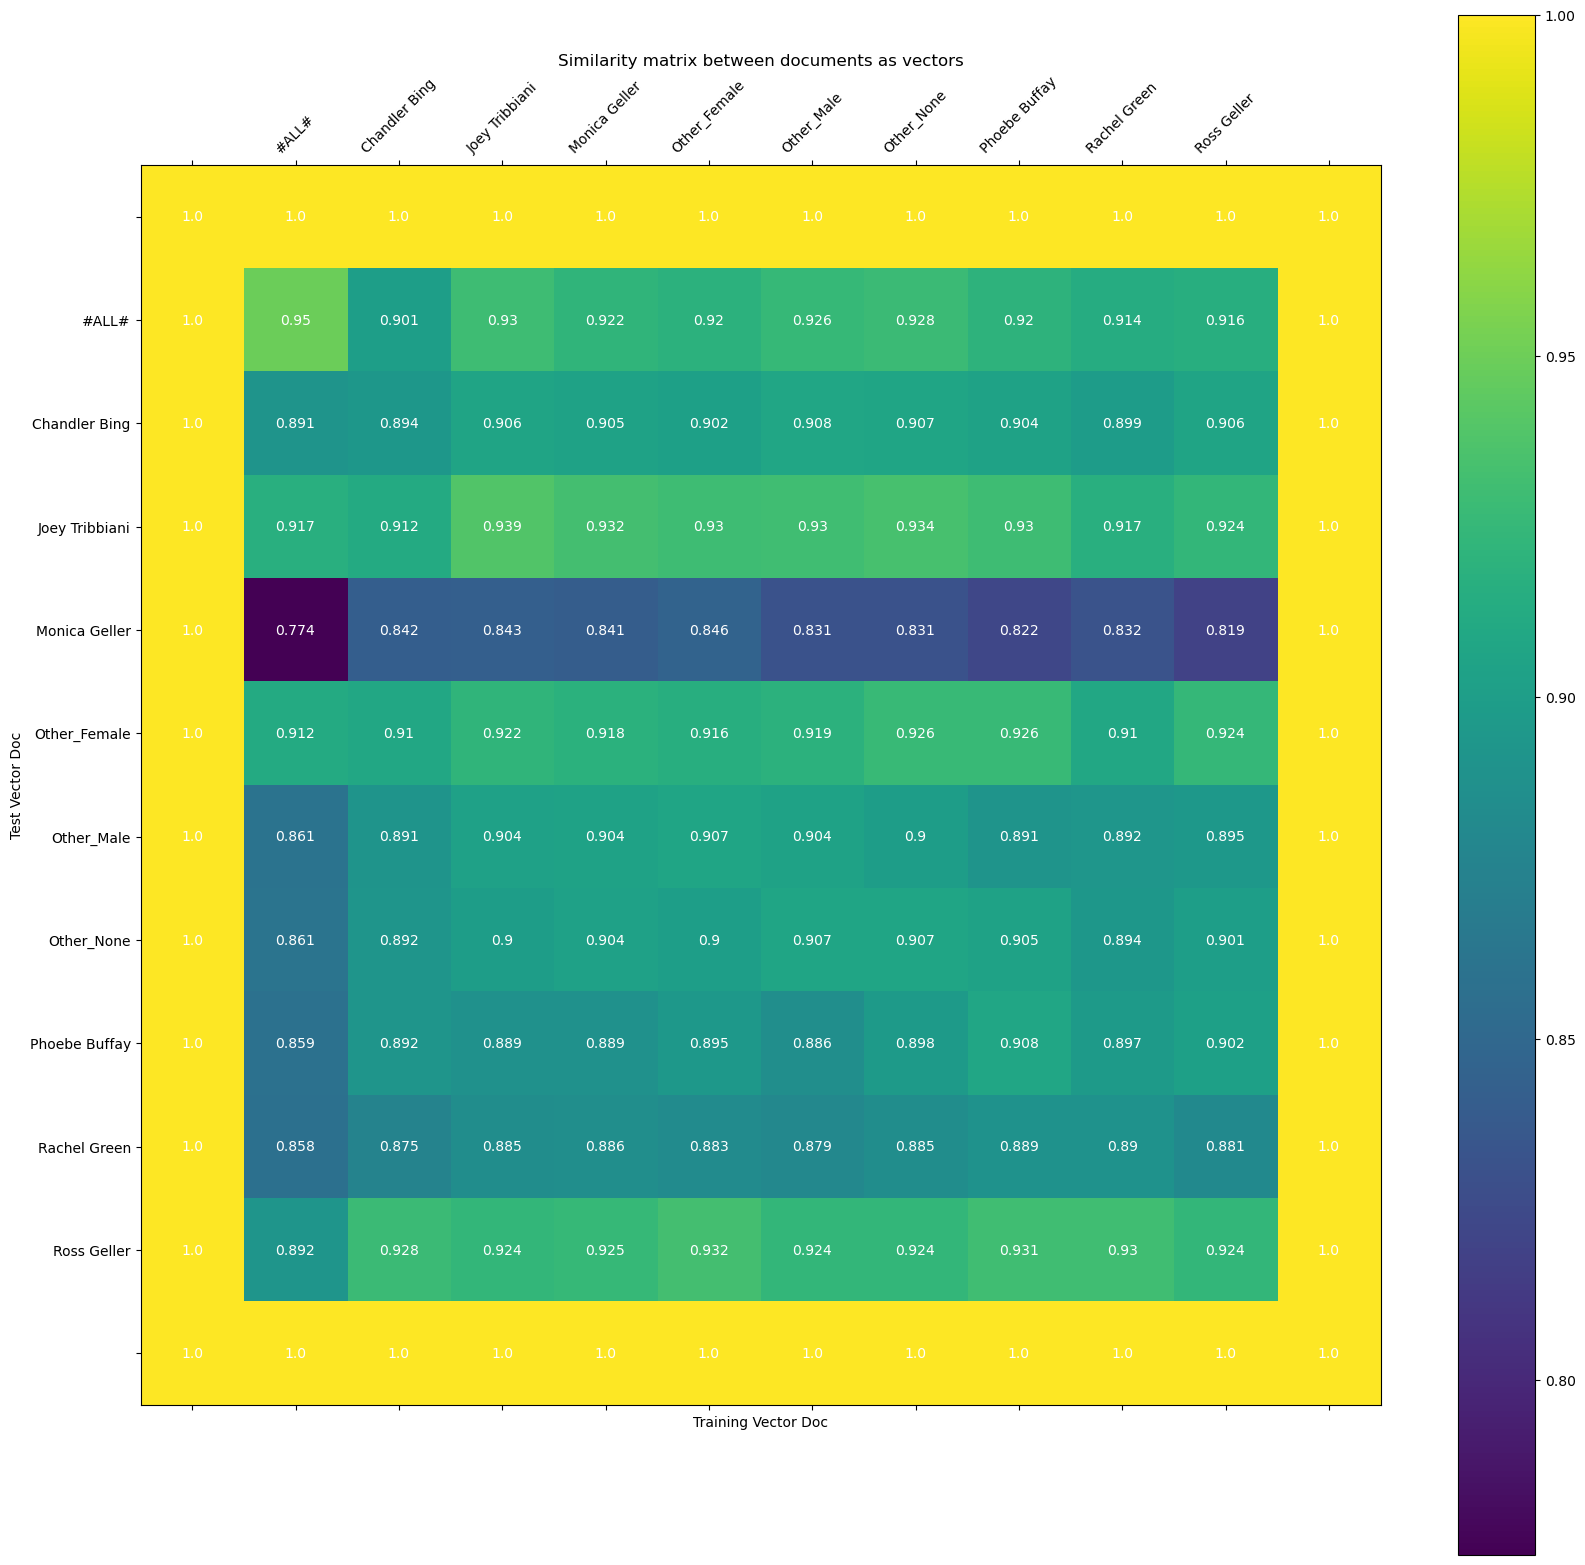

In [33]:
plot_heat_map_similarity(df)

# Q2. Improve linguistic feature extraction (30 marks)
Use the feature extraction techniques you have learned to improve the `to_feature_vector_dictionary` and `create_document_matrix_from_corpus` functions above. Examples of extra features could include extracting n-grams of different lengths and including POS tags. You could also use sentiment analysis or another text classifier's result when applied to the features for each character document. You could even use a gender classifier trained on the same data using the GENDER column **(but DO NOT USE the GENDER column directly in the features for the final vector)**.

Matrix transformation techniques like TF-IDF (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) are commonly used to improve the `create_document_matrix_from_corpus` function, which currently only uses a dictionary vectorizer (`DictVectorizer`) which straight-forwardly maps from the feature dictionaries produced for each character document to a sparse matrix.

Other options include using feature selection/reduction with techniques like minimum/maximum document frequency and/or feature selection like k-best selection using different statistical tests https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html. 

Again, develop your system using the training and validation sets and note the effect/improvement in mean rank with the techniques you use.

In [34]:
from collections import Counter
from nltk.util import ngrams
from nltk import pos_tag
import numpy
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import normalize
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from textblob import TextBlob
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from textblob import TextBlob
import spacy

nlp = spacy.load("en_core_web_sm")

# Initialize global variables
global corpusVectorizer, tfidf_transformer, feature_selector, svd, num_features
corpusVectorizer = DictVectorizer()
# Adjust TF-IDF transformer parameters
tfidf_transformer = TfidfTransformer(
    norm="l2", use_idf=True, smooth_idf=True, sublinear_tf=True
)

# Initialize feature selector with mutual information
# feature_selector = SelectKBest(mutual_info_classif, k='all')  # Adjust k as needed
feature_selector = SelectKBest(mutual_info_classif, k=500)  # Adjust k as needed
num_features = 500
svd = TruncatedSVD(n_components=num_features)


# Modify n-grams extraction to select best n-grams based on frequency
def extract_ngrams(tokens, n_range=(2, 5), top_n=500, min_df=0.25, max_df=1):
    """Extracts n-grams from the token list and selects the most informative ones."""
    vectorizer = CountVectorizer(
        ngram_range=n_range, analyzer="word", min_df=min_df, max_df=max_df
    )
    ngrams = vectorizer.fit_transform([" ".join(tokens)])
    feature_names = vectorizer.get_feature_names_out()
    counts = ngrams.toarray()[0]
    ngram_features = {feature: counts[idx] for idx, feature in enumerate(feature_names)}
    # print("Total n-grams:", len(ngram_features))
    # Select top n-grams by frequency
    top_ngrams = dict(
        sorted(ngram_features.items(), key=lambda item: item[1], reverse=True)[:top_n]
    )
    return top_ngrams


def extract_pos_tags(tokens):
    """Use SpaCy for more granular POS tags."""
    doc = nlp(" ".join(tokens))
    pos_counts = Counter(token.pos_ for token in doc)
    return {"POS_" + tag: count for tag, count in pos_counts.items()}


def extract_sentiment(tokens):
    """Extracts polarity and subjectivity."""
    text = " ".join(tokens)
    sentiment = TextBlob(text).sentiment
    return {
        "sentiment_polarity": sentiment.polarity,
        "sentiment_subjectivity": sentiment.subjectivity,
    }


def lexical_diversity(tokens):
    """Calculates the lexical diversity of a token list."""
    return {"lexical_diversity": len(set(tokens)) / len(tokens) if tokens else 0}


def extract_named_entities(tokens):
    """Extracts named entities from the token list and counts occurrences."""
    doc = nlp(" ".join(tokens))
    entity_counts = Counter(ent.label_ for ent in doc.ents)
    return {"NER_" + label: count for label, count in entity_counts.items()}


def to_feature_vector_dictionary(
    character_doc, extra_features, n_grams=(2, 5), top_n=500, min_df=0.25, max_df=1
):
    """Converts a list of pre-processed tokens and extra features to a Dictionary."""

    # Existing simple count
    counts = Counter(character_doc)
    feature_dict = dict(counts)

    # N-Grams
    ngram_features = extract_ngrams(
        character_doc, n_range=n_grams, top_n=top_n, min_df=min_df, max_df=max_df
    )
    feature_dict.update(ngram_features)

    # POS Tags
    pos_tags = extract_pos_tags(character_doc)
    feature_dict.update(pos_tags)

    # Sentiment
    sentiment_features = extract_sentiment(character_doc)
    feature_dict.update(sentiment_features)

    # Lexical Diversity
    lexical_diversity_feature = lexical_diversity(character_doc)
    feature_dict.update(lexical_diversity_feature)

    # Named Entities
    named_entities = extract_named_entities(character_doc)
    feature_dict.update(named_entities)

    # Add any other extra features
    for feature in extra_features:
        feature_dict[feature] += 1

    # print("Total features:", len(feature_dict))

    return feature_dict


def create_document_matrix_from_corpus(
    corpus,
    fitting=False,
    n_grams=(2, 5),
    top_n=500,
    min_df=0.25,
    max_df=1,
):
    """Method which fits different vectorizers on data and returns a matrix."""

    # Convert documents to feature vectors
    feature_vectors = [
        to_feature_vector_dictionary(
            doc,
            [],
            n_grams=n_grams,
            top_n=top_n,
            min_df=min_df,
            max_df=max_df,
        )
        for name, doc in corpus
    ]

    # Fit and transform with TF-IDF
    if fitting:
        corpusVectorizer.fit(feature_vectors)
        tfidf_transformer.fit(corpusVectorizer.transform(feature_vectors))

        # Optional: Fit the feature selector
        # labels = [name for name, doc in corpus]
        # feature_selector.fit(
        #     tfidf_transformer.transform(corpusVectorizer.transform(feature_vectors)),
        #     labels,
        # )

    transformed_matrix = tfidf_transformer.transform(
        corpusVectorizer.transform(feature_vectors)
    )

    # # Normalize the matrix
    # if normalize_tfidf:
    #     transformed_matrix = normalize(transformed_matrix, norm="l2", axis=1, copy=False)

    # transformed_matrix = feature_selector.transform(transformed_matrix)
    # Dimensionality Reduction using SVD
    if fitting:
        transformed_matrix = svd.fit_transform(transformed_matrix)
    else:
        transformed_matrix = svd.transform(transformed_matrix)

    return transformed_matrix

In [35]:
def evaluate_feature_extraction(configs, training_corpus, train_labels):
    print("#############################################################")
    print("Evaluating feature extraction configurations")
    best_score = float("-inf")
    best_config = None
    best_rank = float("inf")
    all_scores = []

    for config in configs:
        try:
            # Reset the global variables with each new configuration
            global corpusVectorizer, tfidf_transformer, feature_selector, svd, num_features
            corpusVectorizer = DictVectorizer()
            tfidf_transformer = TfidfTransformer(
                norm=config.get("norm", "l2"),
                use_idf=config.get("use_idf", True),
                smooth_idf=config.get("smooth_idf", True),
                sublinear_tf=config.get("sublinear_tf", True),
            )
            feature_selector = SelectKBest(mutual_info_classif, k=config.get("k", 500))
            num_features = config.get("num_features", 500)
            svd = TruncatedSVD(n_components=num_features)

            # Create the training feature matrix with the current configuration
            training_feature_matrix = create_document_matrix_from_corpus(
                training_corpus,
                fitting=True,
                n_grams=config["n_grams"],
                top_n=config["top_n"],
                min_df=config["min_df"],
                max_df=config["max_df"],
            )

            # Get and preprocess the validation data
            val_character_docs = create_character_document_from_dataframe(
                val_data, max_line_count=30
            )
            val_corpus = [
                (name, pre_process(doc, best_tokenizer, expand_contractions))
                for name, doc in val_character_docs.items()
            ]
            val_labels = [name for name, doc in val_corpus]

            # Transform the validation feature matrix with the same current configuration
            val_feature_matrix = create_document_matrix_from_corpus(
                val_corpus,
                fitting=False,
                n_grams=config["n_grams"],
                top_n=config["top_n"],
                min_df=config["min_df"],
                max_df=config["max_df"],
            )

            # Compute IR evaluation scores
            mean_rank, mean_cosine_similarity, acc, df = compute_IR_evaluation_scores(
                training_feature_matrix, val_feature_matrix, train_labels, val_labels
            )

            # Add the scores to the list of all scores for later comparison
            all_scores.append(
                {
                    "config": config,
                    "mean_rank": mean_rank,
                    "mean_cosine_similarity": mean_cosine_similarity,
                    "accuracy": acc,
                }
            )

            # Update the best score and configuration if the current configuration is better
            if acc > best_score or (acc == best_score and mean_rank < best_rank):
                best_score = acc
                best_config = config
                best_rank = mean_rank

        except Exception as e:   
            print("Error with config", config, ":", e)
            continue
        
    print("#############################################################")

    # After the grid search, return the best configuration and its score, along with all evaluated scores
    return best_config, best_score, best_rank, all_scores

In [36]:
# Configurations
# feature_configs = [
#     {
#         "n_grams": (2, 2),
#         "top_n": 500,
#         "min_df": 0.1,
#         "max_df": 1,
#         "norm": "l2",
#         "use_idf": True,
#         "smooth_idf": True,
#         "sublinear_tf": True,
#         "num_features": 500,
#     },
#     {
#         "n_grams": (2, 3),
#         "top_n": 500,
#         "min_df": 0.1,
#         "max_df": 1,
#         "norm": "l2",
#         "use_idf": True,
#         "smooth_idf": True,
#         "sublinear_tf": True,
#         "num_features": 500,
#     }
# ]

# Define the range of values for each parameter
n_grams_options = [(2,3)]
# n_grams_options = [(2, 2), (2, 3), (2, 4)]
top_n_options = [200, 300]
# top_n_options = [500]
min_df_options = [0.05, 0.1]
# min_df_options = [0.15]
max_df_options = [1.0]
norm_options = ["l2"]
use_idf_options = [True]
smooth_idf_options = [True]
sublinear_tf_options = [True]
num_features_options = [200, 300]
# num_features_options = [300, 500]

# Create combinations
combinations = itertools.product(
    n_grams_options,
    top_n_options,
    min_df_options,
    max_df_options,
    norm_options,
    use_idf_options,
    smooth_idf_options,
    sublinear_tf_options,
    num_features_options,
)

# Generate feature extraction configurations
feature_configs = [
    {
        "n_grams": n_grams,
        "top_n": top_n,
        "min_df": min_df,
        "max_df": max_df,
        "norm": norm,
        "use_idf": use_idf,
        "smooth_idf": smooth_idf,
        "sublinear_tf": sublinear_tf,
        "num_features": num_features,
    }
    for n_grams, top_n, min_df, max_df, norm, use_idf, smooth_idf, sublinear_tf, num_features in combinations
]

print("Total feature_configs Combinations : ", len(feature_configs))

# Run the grid search to find the best configuration
# best_config, best_score, best_rank, all_scores = evaluate_feature_extraction(
#     configs, training_corpus, train_labels
# )
(
    best_config_feature_extraction,
    best_score_feature_extraction,
    best_rank_feature_extraction,
    all_scores_feature_extraction,
) = evaluate_feature_extraction(feature_configs, training_corpus, train_labels)

Total feature_configs Combinations :  8
#############################################################
Evaluating feature extraction configurations
lines per character {'Other_None': 30, 'Rachel Green': 30, 'Other_Male': 30, 'Ross Geller': 30, '#ALL#': 18, 'Phoebe Buffay': 30, 'Chandler Bing': 30, 'Monica Geller': 30, 'Joey Tribbiani': 30, 'Other_Female': 30}
mean rank 2.7
mean cosine similarity 0.6493950792944327
5 correct out of 10 / accuracy: 0.5
lines per character {'Other_None': 30, 'Rachel Green': 30, 'Other_Male': 30, 'Ross Geller': 30, '#ALL#': 18, 'Phoebe Buffay': 30, 'Chandler Bing': 30, 'Monica Geller': 30, 'Joey Tribbiani': 30, 'Other_Female': 30}
mean rank 2.7
mean cosine similarity 0.6493950792944325
5 correct out of 10 / accuracy: 0.5
lines per character {'Other_None': 30, 'Rachel Green': 30, 'Other_Male': 30, 'Ross Geller': 30, '#ALL#': 18, 'Phoebe Buffay': 30, 'Chandler Bing': 30, 'Monica Geller': 30, 'Joey Tribbiani': 30, 'Other_Female': 30}
mean rank 2.7
mean cosine s

In [37]:
# Output the scores for all configurations and best configuration
print("Best configuration for feature extraction: ", best_config_feature_extraction)
print("Best accuracy for feature extraction: ", best_score_feature_extraction)
print("Best rank for feature extraction: ", best_rank_feature_extraction)
print("All Results for feature extraction: ", all_scores_feature_extraction)

Best configuration for feature extraction:  {'n_grams': (2, 3), 'top_n': 300, 'min_df': 0.05, 'max_df': 1.0, 'norm': 'l2', 'use_idf': True, 'smooth_idf': True, 'sublinear_tf': True, 'num_features': 200}
Best accuracy for feature extraction:  0.6
Best rank for feature extraction:  2.5
All Results for feature extraction:  [{'config': {'n_grams': (2, 3), 'top_n': 200, 'min_df': 0.05, 'max_df': 1.0, 'norm': 'l2', 'use_idf': True, 'smooth_idf': True, 'sublinear_tf': True, 'num_features': 200}, 'mean_rank': 2.7, 'mean_cosine_similarity': 0.6493950792944327, 'accuracy': 0.5}, {'config': {'n_grams': (2, 3), 'top_n': 200, 'min_df': 0.05, 'max_df': 1.0, 'norm': 'l2', 'use_idf': True, 'smooth_idf': True, 'sublinear_tf': True, 'num_features': 300}, 'mean_rank': 2.7, 'mean_cosine_similarity': 0.6493950792944325, 'accuracy': 0.5}, {'config': {'n_grams': (2, 3), 'top_n': 200, 'min_df': 0.1, 'max_df': 1.0, 'norm': 'l2', 'use_idf': True, 'smooth_idf': True, 'sublinear_tf': True, 'num_features': 200}, '

In [38]:
# Now you can process the entire corpus with the best configuration
training_corpus = [
    (name, pre_process(doc, best_tokenizer, expand_contractions))
    for name, doc in train_character_docs.items()
]

# Create the training feature matrix
training_feature_matrix = create_document_matrix_from_corpus(
    training_corpus,
    fitting=True,
    n_grams=best_config_feature_extraction["n_grams"],
    top_n=best_config_feature_extraction["top_n"],
    min_df=best_config_feature_extraction["min_df"],
    max_df=best_config_feature_extraction["max_df"],
)

# Get and preprocess the validation data
val_character_docs = create_character_document_from_dataframe(
    val_data, max_line_count=30
)
val_corpus = [
    (name, pre_process(doc, best_tokenizer, expand_contractions))
    for name, doc in val_character_docs.items()
]
val_labels = [name for name, doc in val_corpus]

# Just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(
    val_corpus,
    fitting=False,
    n_grams=best_config_feature_extraction["n_grams"],
    top_n=best_config_feature_extraction["top_n"],
    min_df=best_config_feature_extraction["min_df"],
    max_df=best_config_feature_extraction["max_df"],
)

lines per character {'Other_None': 30, 'Rachel Green': 30, 'Other_Male': 30, 'Ross Geller': 30, '#ALL#': 18, 'Phoebe Buffay': 30, 'Chandler Bing': 30, 'Monica Geller': 30, 'Joey Tribbiani': 30, 'Other_Female': 30}


In [39]:
print("Sample after preprocessing: ", training_corpus[0])
# Feature matrix contains dense vectors
print("Feature matrix shape after modified feature extraction: ", training_feature_matrix.shape)

Sample after preprocessing:  ('Monica Geller', ["there's", 'nothing', 'tell', "he's", 'guy', 'work', '_eol_', 'okay', 'everybody', 'relax', 'date', 'sex', '_eol_', 'look', '_eol_', 'okay', 'sweetie', '_eol_', 'carol', 'move', 'stuff', 'today', '_eol_', 'let', 'get', 'coffee', '_eol_', '_eol_', 'oh', 'hysterical', 'phone', 'call', 'get', 'woman', 'sob', "i'll", '"', 'wrong', 'number', '"', '_eol_', 'rachel', '_eol_', 'de-caff', 'okay', 'everybody', 'rachel', 'lincoln', 'high', 'survivor', 'everybody', 'chandler', 'phoebe', 'joey', 'remember', 'brother', 'ross', '_eol_', 'wanna', 'tell', 'wait', 'wet', '_eol_', 'invite', '_eol_', "i'm", 'guess', 'big', 'pipe', 'organ', 'happy', '_eol_', 'guess', "we've", 'establish', "who's", 'stay', 'breathe', 'breathe', "that's", 'try', 'think', 'nice', 'okay', 'look', "y'know", 'independence', 'take', 'control', 'life', 'whole', 'thing', '_eol_', 'joey', 'stop', 'hit', 'day', '_eol_', 'god', 'buzz', '_eol_', 'joey', 'wait', 'real', 'date', 'tonight', 

In [40]:
mean_rank, mean_cosine_similarity, acc, df = compute_IR_evaluation_scores(
    training_feature_matrix, val_feature_matrix, train_labels, val_labels
)

mean rank 2.5
mean cosine similarity 0.632322496471775
6 correct out of 10 / accuracy: 0.6


/tmp/ipykernel_3188/656623868.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(["doc1", "doc2"])[df["doc1"] == target]["similarity"]:
/tmp/ipykernel_3188/656623868.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(["doc1", "doc2"])[df["doc1"] == target]["similarity"]:
/tmp/ipykernel_3188/656623868.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(["doc1", "doc2"])[df["doc1"] == target]["similarity"]:
/tmp/ipykernel_3188/656623868.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(["doc1", "doc2"])[df["doc1"] == target]["similarity"]:
/tmp/ipykernel_3188/656623868.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(["doc1", "doc2"])[df["doc1"] == target]["similarity"]:
/tmp/ipykernel_3188/656623868.

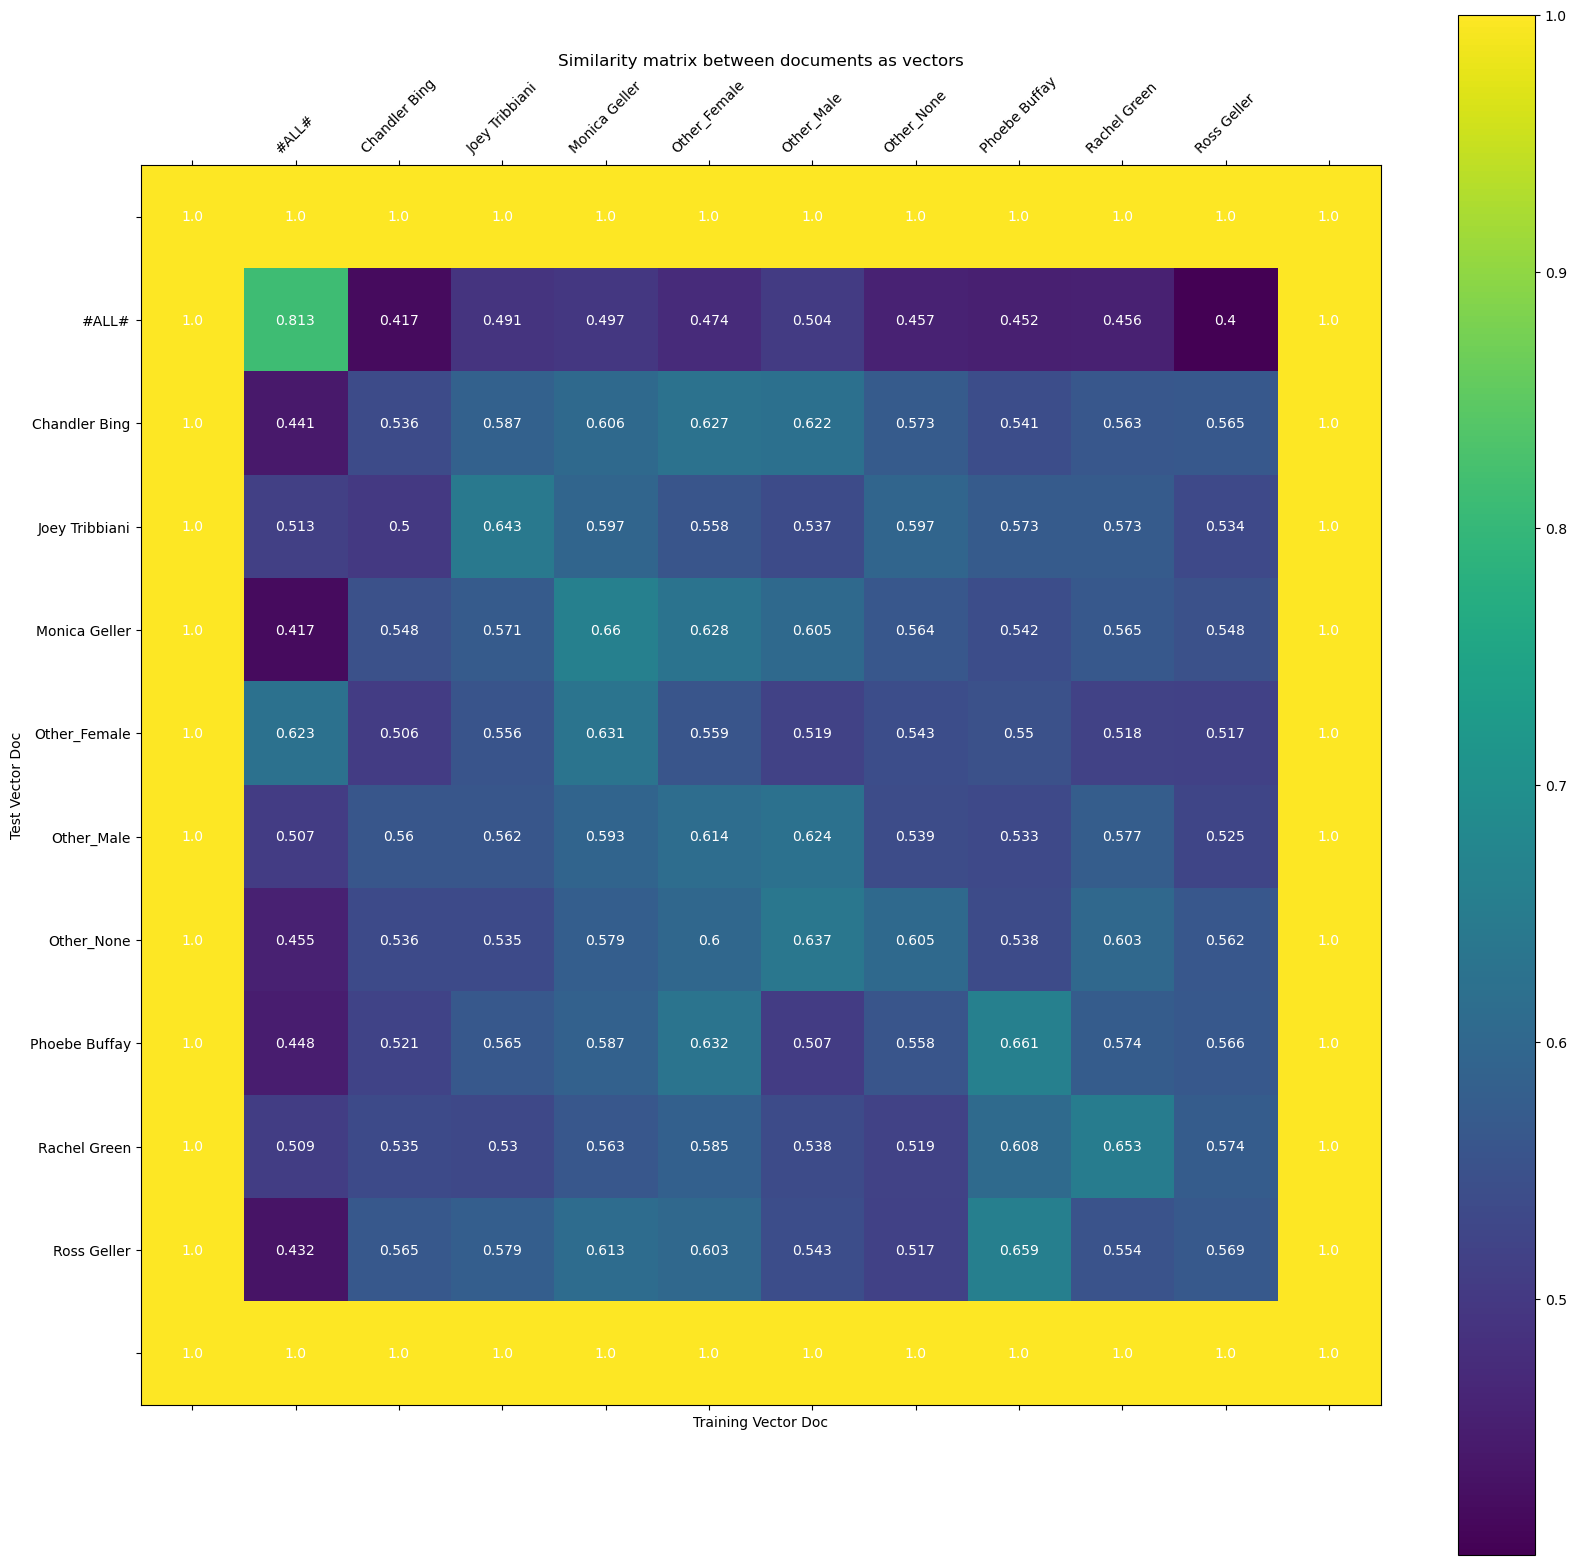

In [41]:
plot_heat_map_similarity(df)

# Q3. Add dialogue context and scene features (15 marks)
Adjust `create_character_document_from_dataframe` and the other functions appropriately so the data incorporates the context of the line spoken by the characters in terms of the lines spoken by other characters in the same scene (before and after the target character's lines). HINT: you should use the *Episode* and *Scene* columns to check which characters are in the same scene to decide whether to include their lines or not. Only the lines from the same *Scene* can be added as the context as lines from different *Scene* are irrelevant.  **(but DO NOT USE the GENDER and CHARACTER columns directly)**.

In [42]:
def create_character_document_from_dataframe(df, max_line_count, context_size=1):
    character_docs = {}
    character_line_count = {}

    # Group by episode and scene for context
    grouped = df.groupby(["Episode", "Scene"])

    for _, group in grouped:
        # Reset index for proper iteration
        group = group.reset_index(drop=True)

        for idx, row in group.iterrows():
            name = row["Character_name"]
            line = str(row["Line"]).strip()

            if line in ["nan", "", "None"]:
                continue

            if name not in character_docs:
                character_docs[name] = {"lines": [], "count": 0}

            if character_docs[name]["count"] < max_line_count:
                # Consider only lines within the same scene
                context_lines = []
                for context_idx in range(max(0, idx - context_size), min(len(group), idx + context_size + 1)):
                    # Exclude the target line itself
                    if context_idx != idx:
                        context_line = str(group.iloc[context_idx]["Line"]).strip()
                        if context_line not in ["nan", "", "None"]:
                            context_lines.append(context_line)

                # Highlight the target line and combine with context
                combined_line = " _EOL_ ".join(context_lines[:context_size]) + \
                                f" <TARGET_LINE> {line} <TARGET_LINE> " + \
                                " _EOL_ ".join(context_lines[context_size:])
                character_docs[name]["lines"].append(combined_line + " _EOL_ ")
                character_docs[name]["count"] += 1

    # Compile final documents and counts
    for name, data in character_docs.items():
        character_docs[name] = "".join(data["lines"])
        character_line_count[name] = data["count"]

    print("lines per character", character_line_count)
    return character_docs

In [43]:
def evaluate_create_character_document_from_dataframe(configs, train_data):
    print("#############################################################")
    print("Evaluating create_character_document_from_dataframe configurations")
    best_score = float("-inf")
    best_config = None
    best_rank = float("inf")
    all_scores = []

    for config in configs:
        try:
            # print out the number of words each character has in the training set
            # # only use the first 300 lines of each character
            # train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
            # print('Num. Characters: ',len(train_character_docs.keys()),"\n")
            # total_words = 0
            # for name in train_character_docs.keys():
            #     print(name, 'Number of Words: ',len(train_character_docs[name].split()))
            #     total_words += len(train_character_docs[name].split())
            # print("total words", total_words)

            eval_train_character_docs = create_character_document_from_dataframe(
                train_data, max_line_count=300, context_size=config["context_size"]
            )
            print("Num. Characters: ", len(eval_train_character_docs.keys()), "\n")
            total_words = 0
            for name in eval_train_character_docs.keys():
                print(
                    name, "Number of Words: ", len(eval_train_character_docs[name].split())
                )
                total_words += len(eval_train_character_docs[name].split())
            print("total words", total_words)

            # pre-process the training corpus using the best configuration for Q1
            processed_training_corpus = [
                (
                    name,
                    pre_process(
                        doc,
                        # best_config["tokenizer"],
                        best_config_preprocess["tokenizer"],
                        # best_config["expand_contractions"],
                        best_config_preprocess["expand_contractions"],
                    ),
                )
                for name, doc in eval_train_character_docs.items()
            ]

            # create the training feature matrix with best configuration for Q2
            training_feature_matrix = create_document_matrix_from_corpus(
                processed_training_corpus,
                fitting=True,
                n_grams=best_config_feature_extraction["n_grams"],
                top_n=best_config_feature_extraction["top_n"],
                min_df=best_config_feature_extraction["min_df"],
                # max_df=best_config["max_df"],
                max_df=best_config_feature_extraction["max_df"],
            )

            # get and pre-process the validation data
            val_character_docs = create_character_document_from_dataframe(
                val_data, max_line_count=30, context_size=config["context_size"]
            )
            val_corpus = [
                (
                    name,
                    pre_process(
                        doc,
                        # best_config["tokenizer"],
                        best_config_preprocess["tokenizer"],
                        # best_config["expand_contractions"],
                        best_config_preprocess["expand_contractions"],
                    ),
                )
                for name, doc in val_character_docs.items()
            ]

            # just transform the val_feature_matrix, don't fit
            val_feature_matrix = create_document_matrix_from_corpus(
                val_corpus,
                fitting=False,
                n_grams=best_config_feature_extraction["n_grams"],
                top_n=best_config_feature_extraction["top_n"],
                min_df=best_config_feature_extraction["min_df"],
                max_df=best_config_feature_extraction["max_df"],
            )

            # compute IR evaluation scores
            mean_rank, mean_cosine_similarity, acc, df = compute_IR_evaluation_scores(
                training_feature_matrix, val_feature_matrix, train_labels, val_labels
            )

            # add the scores to the list of all scores for later comparison
            all_scores.append(
                {
                    "config": config,
                    "mean_rank": mean_rank,
                    "mean_cosine_similarity": mean_cosine_similarity,
                    "accuracy": acc,
                }
            )

            # update the best score and configuration if the current configuration is better
            if acc > best_score or (acc == best_score and mean_rank < best_rank):
                best_score = acc
                best_config = config
                best_rank = mean_rank
        
        except Exception as e:
            print("Error with config", config, ":", e)
            continue
    
    print("#############################################################")

    return best_config, best_score, best_rank, all_scores

In [44]:
# configs = [
#     {"context_size": 1},
#     {"context_size": 2},
#     {"context_size": 3},
# ]
combinations = [1, 2]  # Example context sizes
character_doc_configs = [{"context_size": context_size} for context_size in combinations]
print("Total character_doc_configs Combinations : ", len(character_doc_configs))

best_config_character_doc, best_score_character_doc, best_rank_character_doc, all_scores_character_doc = evaluate_create_character_document_from_dataframe(
    character_doc_configs, train_data
)

Total character_doc_configs Combinations :  2
#############################################################
Evaluating create_character_document_from_dataframe configurations
lines per character {'Monica Geller': 300, 'Joey Tribbiani': 300, 'Chandler Bing': 300, 'Phoebe Buffay': 300, '#ALL#': 300, 'Ross Geller': 300, 'Rachel Green': 300, 'Other_None': 300, 'Other_Female': 300, 'Other_Male': 300}
Num. Characters:  10 

Monica Geller Number of Words:  9843
Joey Tribbiani Number of Words:  9062
Chandler Bing Number of Words:  9954
Phoebe Buffay Number of Words:  9385
#ALL# Number of Words:  7712
Ross Geller Number of Words:  9002
Rachel Green Number of Words:  10244
Other_None Number of Words:  8961
Other_Female Number of Words:  9481
Other_Male Number of Words:  9620
total words 93264
lines per character {'Other_None': 30, 'Rachel Green': 30, 'Other_Male': 30, 'Ross Geller': 30, '#ALL#': 18, 'Phoebe Buffay': 30, 'Chandler Bing': 30, 'Monica Geller': 30, 'Joey Tribbiani': 30, 'Other_Femal

In [45]:
# Output the scores for all configurations and best configuration
print("Best configuration for character document creation: ", best_config_character_doc)
print("Best accuracy for character document creation: ", best_score_character_doc)
print("Best rank for character document creation: ", best_rank_character_doc)
print("All Results for character document creation: ", all_scores_character_doc)

Best configuration for character document creation:  {'context_size': 1}
Best accuracy for character document creation:  0.6
Best rank for character document creation:  3.1
All Results for character document creation:  [{'config': {'context_size': 1}, 'mean_rank': 3.1, 'mean_cosine_similarity': 0.6516434303375759, 'accuracy': 0.6}, {'config': {'context_size': 2}, 'mean_rank': 4.0, 'mean_cosine_similarity': 0.6566296098749552, 'accuracy': 0.4}]


In [46]:
train_character_docs = create_character_document_from_dataframe(
    train_data,
    max_line_count=300,
    context_size=best_config_character_doc["context_size"],
)

# pre-process the training corpus using the best configuration for Q1
processed_training_corpus = [
    (
        name,
        pre_process(
            doc,
            # best_config["tokenizer"],
            best_config_preprocess["tokenizer"],
            # best_config["expand_contractions"],
            best_config_preprocess["expand_contractions"],
        ),
    )
    for name, doc in train_character_docs.items()
]

# create the training feature matrix with best configuration for Q2
training_feature_matrix = create_document_matrix_from_corpus(
    processed_training_corpus,
    fitting=True,
    n_grams=best_config_feature_extraction["n_grams"],
    top_n=best_config_feature_extraction["top_n"],
    min_df=best_config_feature_extraction["min_df"],
    # max_df=best_config["max_df"],
    max_df=best_config_feature_extraction["max_df"],
)

# get and pre-process the validation data
val_character_docs = create_character_document_from_dataframe(
    val_data, max_line_count=30, context_size=best_config_character_doc["context_size"]
)

val_corpus = [
    (
        name,
        pre_process(
            doc,
            # best_config["tokenizer"],
            best_config_preprocess["tokenizer"],
            # best_config["expand_contractions"],
            best_config_preprocess["expand_contractions"],
        ),
    )
    for name, doc in val_character_docs.items()
]

# just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(
    val_corpus,
    fitting=False,
    n_grams=best_config_feature_extraction["n_grams"],
    top_n=best_config_feature_extraction["top_n"],
    min_df=best_config_feature_extraction["min_df"],
    max_df=best_config_feature_extraction["max_df"],
)

lines per character {'Monica Geller': 300, 'Joey Tribbiani': 300, 'Chandler Bing': 300, 'Phoebe Buffay': 300, '#ALL#': 300, 'Ross Geller': 300, 'Rachel Green': 300, 'Other_None': 300, 'Other_Female': 300, 'Other_Male': 300}
lines per character {'Other_None': 30, 'Rachel Green': 30, 'Other_Male': 30, 'Ross Geller': 30, '#ALL#': 18, 'Phoebe Buffay': 30, 'Chandler Bing': 30, 'Monica Geller': 30, 'Joey Tribbiani': 30, 'Other_Female': 30}


In [47]:
mean_rank, mean_cosine_similarity, acc, df = compute_IR_evaluation_scores(
    training_feature_matrix, val_feature_matrix, train_labels, val_labels
)

mean rank 3.1
mean cosine similarity 0.6516434303375755
6 correct out of 10 / accuracy: 0.6


/tmp/ipykernel_3188/656623868.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(["doc1", "doc2"])[df["doc1"] == target]["similarity"]:
/tmp/ipykernel_3188/656623868.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(["doc1", "doc2"])[df["doc1"] == target]["similarity"]:
/tmp/ipykernel_3188/656623868.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(["doc1", "doc2"])[df["doc1"] == target]["similarity"]:
/tmp/ipykernel_3188/656623868.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(["doc1", "doc2"])[df["doc1"] == target]["similarity"]:
/tmp/ipykernel_3188/656623868.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(["doc1", "doc2"])[df["doc1"] == target]["similarity"]:
/tmp/ipykernel_3188/656623868.

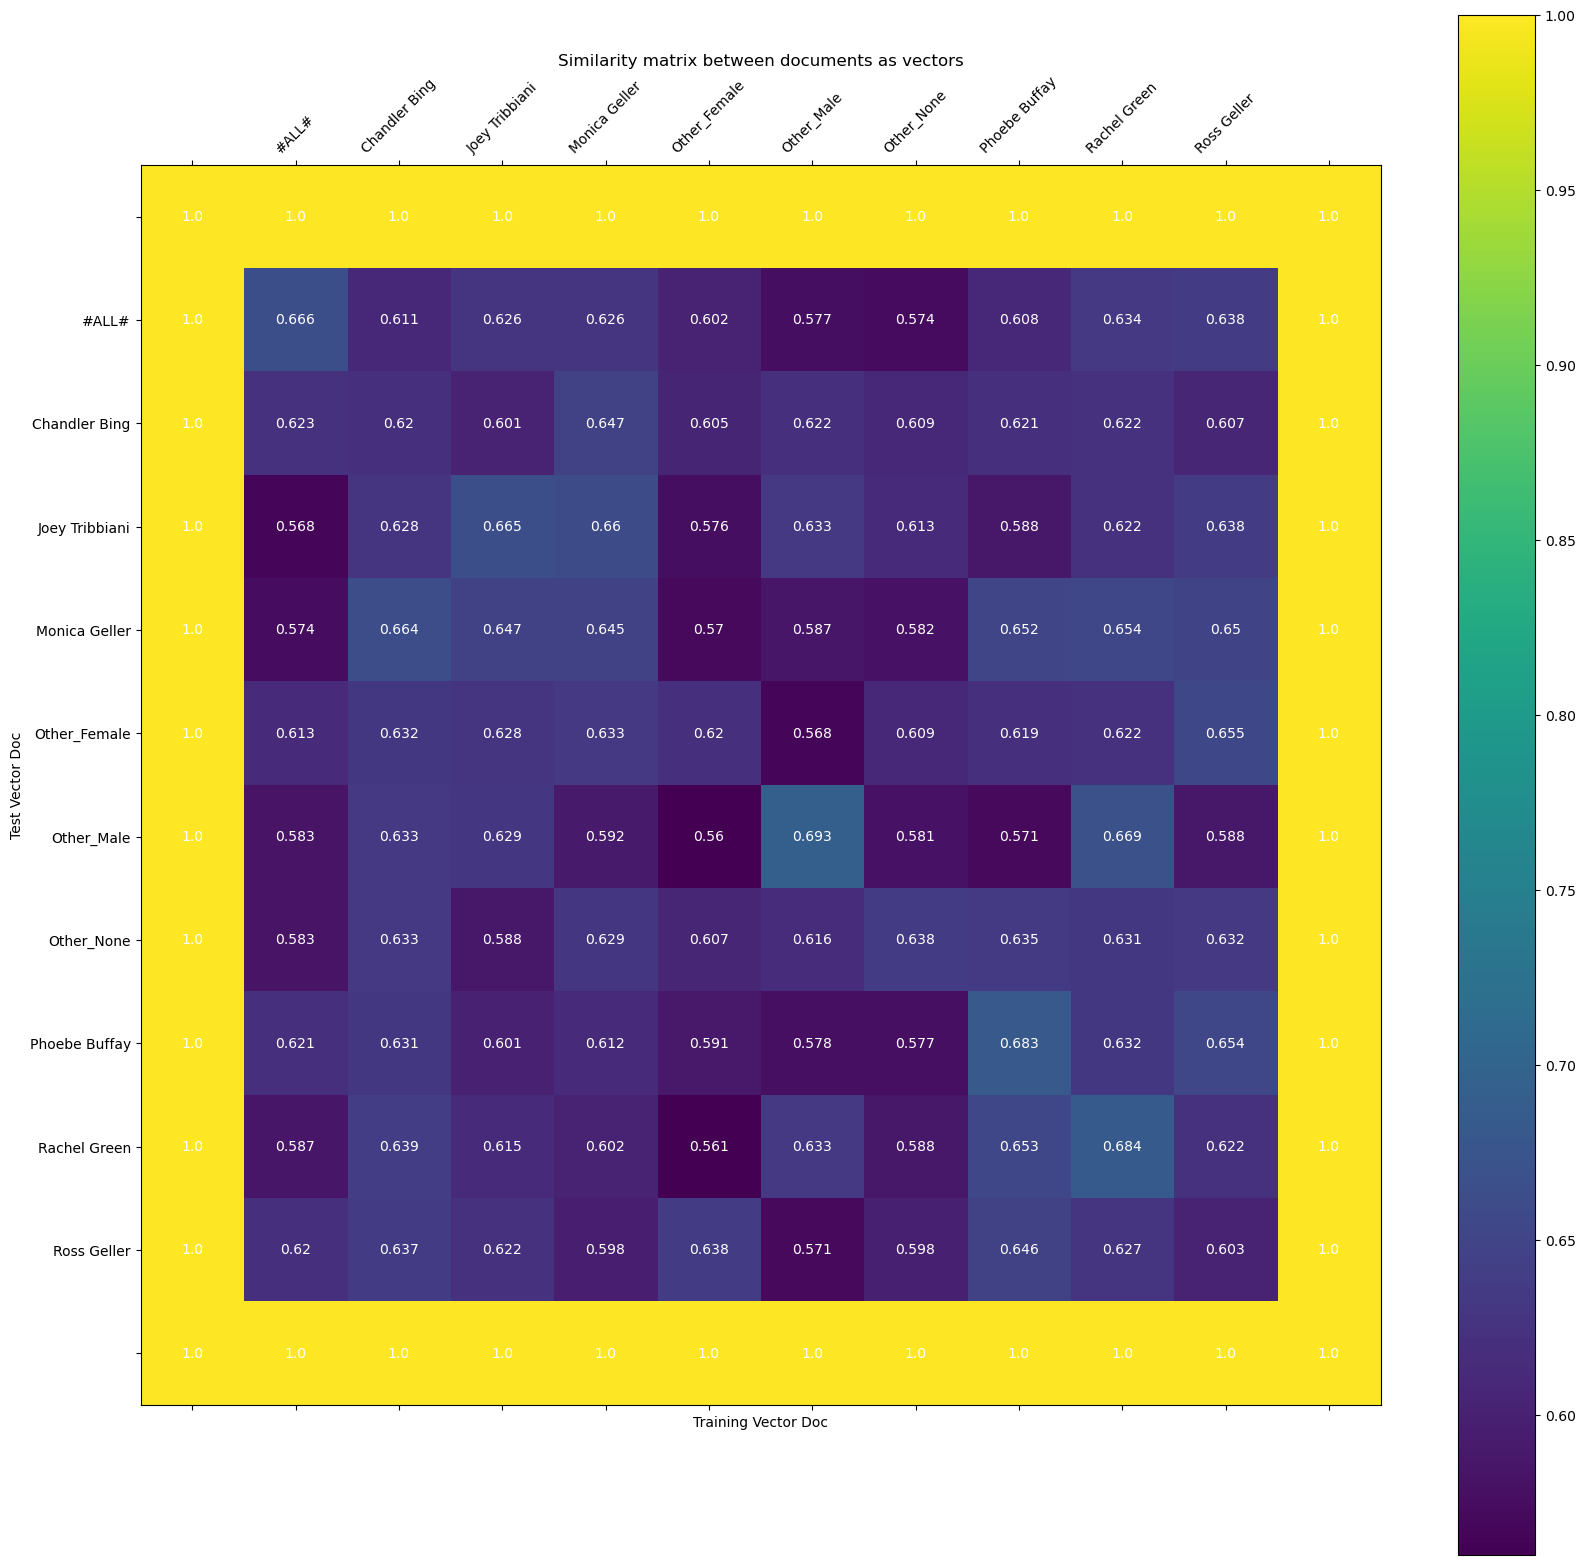

In [48]:
plot_heat_map_similarity(df)

# Q4. Parameter Search (15 marks)
It is a good practice to conduct a systematic parameter search instead of a random search as this will give you more 
reliable results. Given the scope of this assignment, it is possible to conduct a **grid search** on options you decided to try within the individual questions. The grid search should be done within the individual questions (i.e. Q1-Q3), and the later question should adopt the best settings from the previous questions. There is no need to do a grid search over all configurations from all questions as this will easily make the search unrealistic. E.g. Suppose we need 32, 90, and 4 runs to finish the grid search within questions, a cross-question grid search would need 32x90x4 = 11520 runs!                                                                      

In [49]:
train_character_docs = create_character_document_from_dataframe(
    train_data,
    max_line_count=300,
    context_size=best_config_character_doc["context_size"],
)

# pre-process the training corpus using the best configuration for Q1
processed_training_corpus = [
    (
        name,
        pre_process(
            doc,
            best_config_preprocess["tokenizer"],
            best_config_preprocess["expand_contractions"],
        ),
    )
    for name, doc in train_character_docs.items()
]

# create the training feature matrix with best configuration for Q2
training_feature_matrix = create_document_matrix_from_corpus(
    processed_training_corpus,
    fitting=True,
    n_grams=best_config_feature_extraction["n_grams"],
    top_n=best_config_feature_extraction["top_n"],
    min_df=best_config_feature_extraction["min_df"],
    max_df=best_config_feature_extraction["max_df"],
)

# get and pre-process the validation data
val_character_docs = create_character_document_from_dataframe(
    val_data, max_line_count=30, context_size=best_config_character_doc["context_size"]
)

val_corpus = [
    (
        name,
        pre_process(
            doc,
            best_config_preprocess["tokenizer"],
            best_config_preprocess["expand_contractions"],
        ),
    )
    for name, doc in val_character_docs.items()
]

# just transform the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(
    val_corpus,
    fitting=False,
    n_grams=best_config_feature_extraction["n_grams"],
    top_n=best_config_feature_extraction["top_n"],
    min_df=best_config_feature_extraction["min_df"],
    max_df=best_config_feature_extraction["max_df"],
)

lines per character {'Monica Geller': 300, 'Joey Tribbiani': 300, 'Chandler Bing': 300, 'Phoebe Buffay': 300, '#ALL#': 300, 'Ross Geller': 300, 'Rachel Green': 300, 'Other_None': 300, 'Other_Female': 300, 'Other_Male': 300}
lines per character {'Other_None': 30, 'Rachel Green': 30, 'Other_Male': 30, 'Ross Geller': 30, '#ALL#': 18, 'Phoebe Buffay': 30, 'Chandler Bing': 30, 'Monica Geller': 30, 'Joey Tribbiani': 30, 'Other_Female': 30}


In [50]:
mean_rank, mean_cosine_similarity, acc, df = compute_IR_evaluation_scores(
    training_feature_matrix, val_feature_matrix, train_labels, val_labels
)

mean rank 3.1
mean cosine similarity 0.651643430337576
6 correct out of 10 / accuracy: 0.6


# Q5. Analyse the similarity results (10 marks)
From your system so far run on the training/validation sets, identify the heldout character vectors ranked closest to each character's training vector which are not the character themselves, and those furthest away, as displayed using the `plot_heat_map_similarity` function. In your report, try to ascribe reasons why this is the case, particularly for those where there isn't a successful highest match between the target character in the training set and that character's vector in the heldout set yet. Observations you could make include how their language use is similar, resulting in similar word or ngram features.

/tmp/ipykernel_3188/656623868.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(["doc1", "doc2"])[df["doc1"] == target]["similarity"]:
/tmp/ipykernel_3188/656623868.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(["doc1", "doc2"])[df["doc1"] == target]["similarity"]:
/tmp/ipykernel_3188/656623868.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(["doc1", "doc2"])[df["doc1"] == target]["similarity"]:
/tmp/ipykernel_3188/656623868.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(["doc1", "doc2"])[df["doc1"] == target]["similarity"]:
/tmp/ipykernel_3188/656623868.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  for x in df.sort_values(["doc1", "doc2"])[df["doc1"] == target]["similarity"]:
/tmp/ipykernel_3188/656623868.

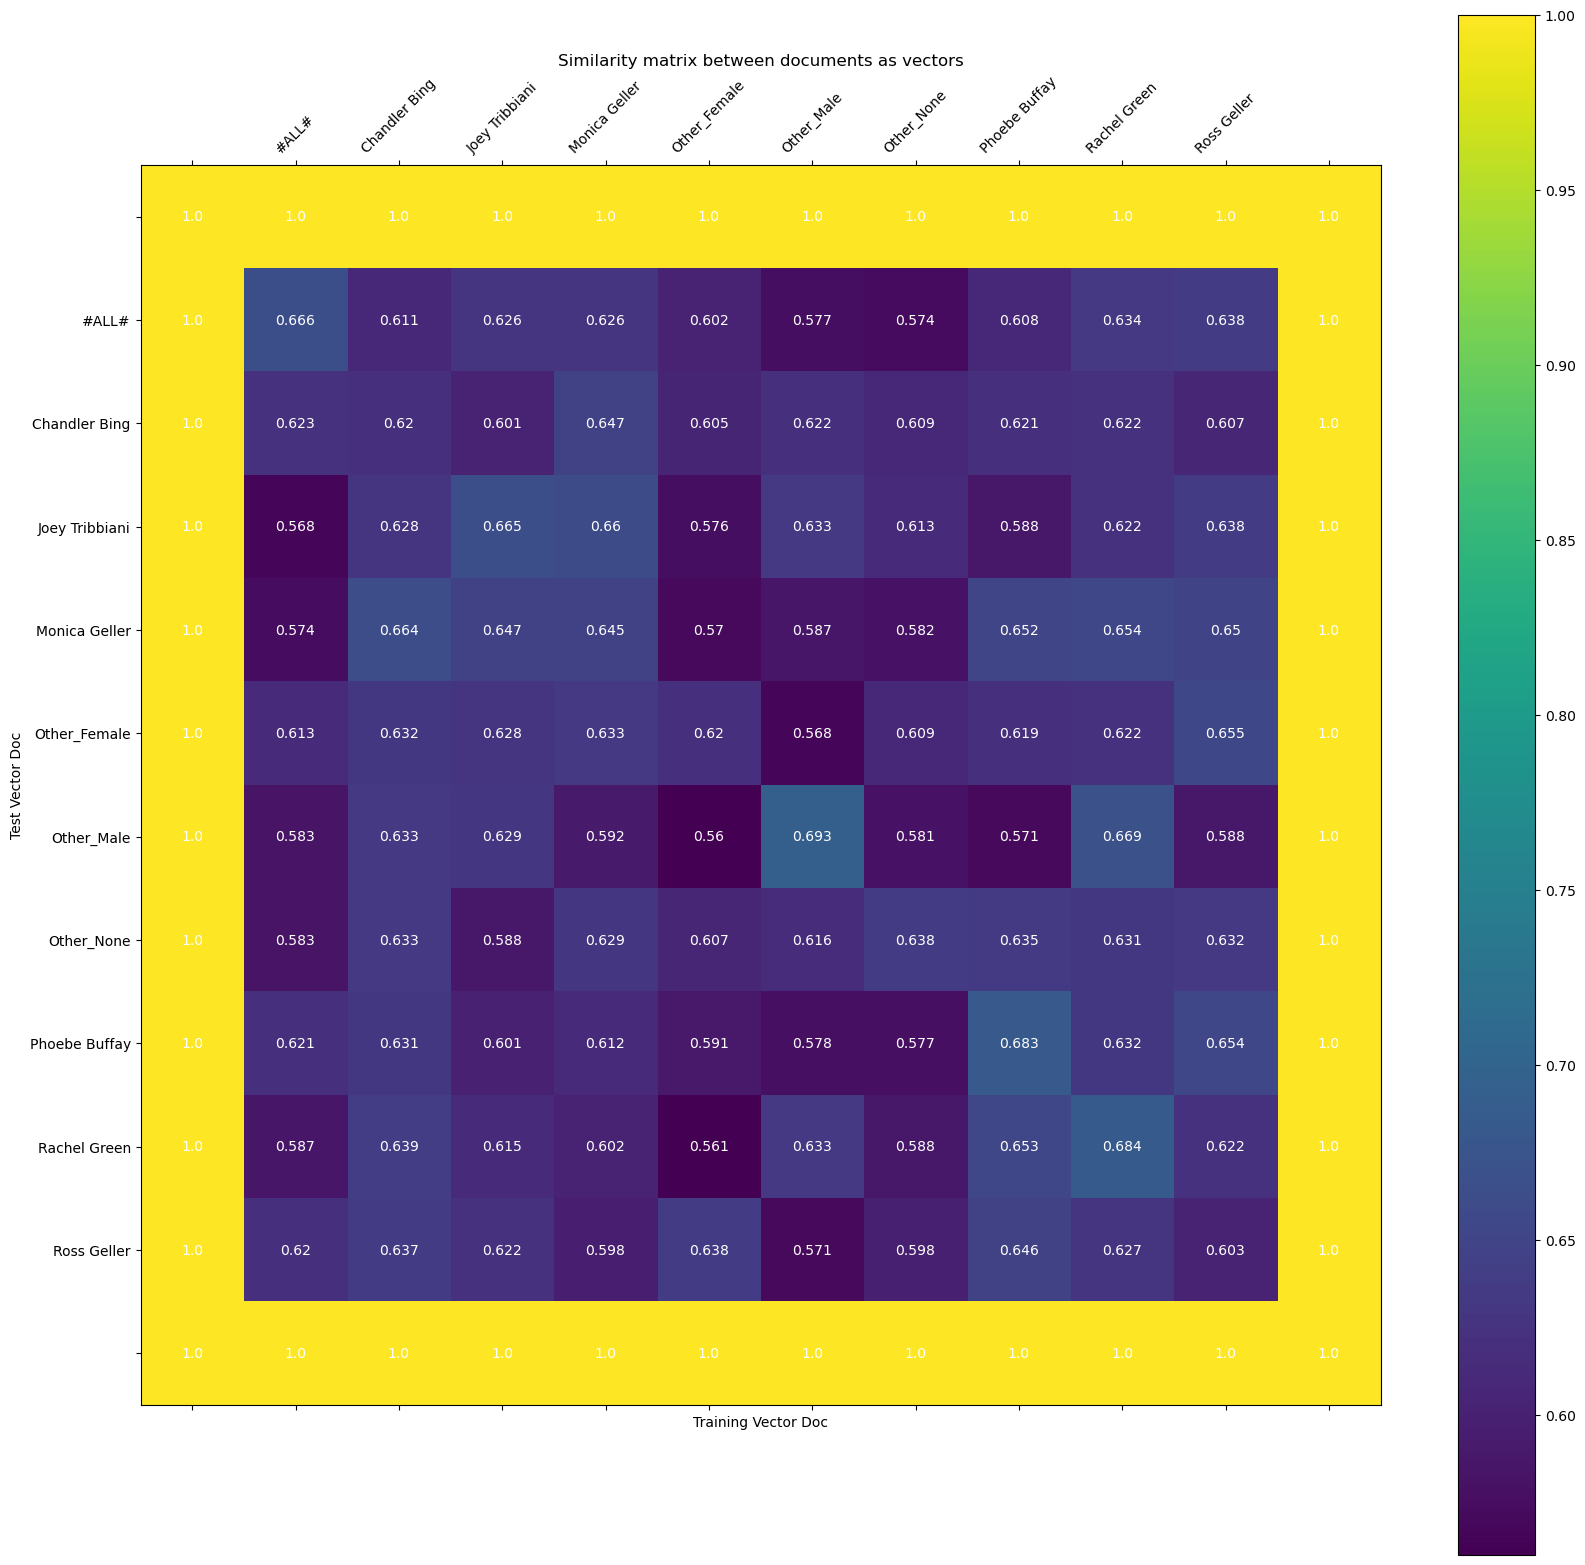

In [51]:
plot_heat_map_similarity(df)

# Q6. Run on final test data  (10 marks)
Test your best system using the code below to train on the training data (using the first 300 lines per character maximum) and do the final testing on the test file (using the first 30 lines per character maximum).

Make any necessary adjustments such that it runs in the same way as the training/testing regime you developed above- e.g. making sure any transformer objects are initialized before `create_document_matrix_from_corpus` is called. Make sure your best system is left in the notebook and it is clear what the mean rank and accuracy of document selection are on the test data.

In [52]:
train_character_docs = create_character_document_from_dataframe(
    train_data, max_line_count=300, context_size=best_config_character_doc["context_size"]
)

# pre-process the training corpus using the best configuration for Q1
processed_training_corpus = [
    (
        name,
        pre_process(
            doc,
            # best_config["tokenizer"],
            best_config_preprocess["tokenizer"],
            # best_config["expand_contractions"],
            # best_config_combined["preprocess"]["expand_contractions"],
            best_config_preprocess["expand_contractions"],
        ),
    )
    for name, doc in train_character_docs.items()
]

# create the training feature matrix with best configuration for Q2
training_feature_matrix = create_document_matrix_from_corpus(
    processed_training_corpus,
    fitting=True,
    n_grams=best_config_feature_extraction["n_grams"],
    top_n=best_config_feature_extraction["top_n"],
    min_df=best_config_feature_extraction["min_df"],
    # max_df=best_config["max_df"],
    max_df=best_config_feature_extraction["max_df"],
)

# get the test data using 40 lines per character
test_character_docs = create_character_document_from_dataframe(
    test_data,
    max_line_count=40,
    context_size=best_config_character_doc["context_size"],
)

# create list of pairs of (character name, pre-processed character)
test_corpus = [
    (
        name,
        pre_process(
            doc,
            best_config_preprocess["tokenizer"],
            # best_config_combined["preprocess"]["expand_contractions"],
            best_config_preprocess["expand_contractions"],
        ),
    )
    for name, doc in sorted(test_character_docs.items())
]
test_labels = [name for name, doc in test_corpus]

# Just transform the test_feature_matrix, don't fit
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)

mean_rank, mean_cosine_simliarity, acc, df = compute_IR_evaluation_scores(
    training_feature_matrix, test_feature_matrix, train_labels, test_labels
)

lines per character {'Monica Geller': 300, 'Joey Tribbiani': 300, 'Chandler Bing': 300, 'Phoebe Buffay': 300, '#ALL#': 300, 'Ross Geller': 300, 'Rachel Green': 300, 'Other_None': 300, 'Other_Female': 300, 'Other_Male': 300}
lines per character {'Ross Geller': 40, 'Joey Tribbiani': 40, 'Chandler Bing': 40, 'Other_Female': 40, 'Other_None': 40, '#ALL#': 11, 'Monica Geller': 40, 'Rachel Green': 40, 'Phoebe Buffay': 40, 'Other_Male': 40}
mean rank 2.0
mean cosine similarity 0.6726246309722403
6 correct out of 10 / accuracy: 0.6
